# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

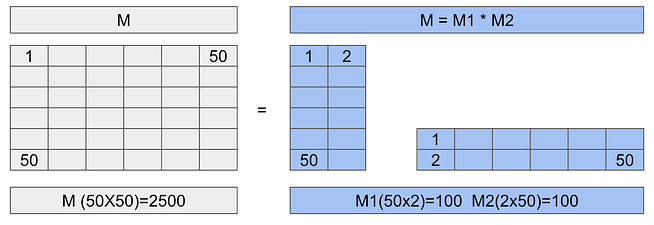

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-1b1"  # bigscience/bloom-1b1: 1.1B params, medium Bloom model, good balance of capability and memory use.


tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [17]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [25]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['I want you to act as a motivational coach. I will provide some information about an individual and it may be difficult for them at times, but they are still able to achieve their goals through the help of me or my team members who have been working hard on improving themselves in order that eventually all can']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
from datasets import load_dataset

dataset = "fka/awesome-chatgpt-prompts"



try:
    # Load train split explicitly
    data = load_dataset("fka/awesome-chatgpt-prompts", split="train")
except Exception as e:
    print("Error loading dataset:", e)
    # Try loading without split as fallback (might still fail)
    data = load_dataset("fka/awesome-chatgpt-prompts", split="train")

# Check columns
print("Columns in dataset:", data.column_names)

# Tokenize the 'prompt' column
def tokenize_function(samples):
    return tokenizer(samples["prompt"])

tokenized_data = data.map(tokenize_function, batched=True)

# Select first 50 samples
train_sample = tokenized_data.select(range(50))

# Remove 'act' column if exists
if "act" in train_sample.column_names:
    train_sample = train_sample.remove_columns('act')

print(train_sample)

# Optionally display in Jupyter or Colab
# from IPython.display import display
# display(train_sample)


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Columns in dataset: ['act', 'prompt']


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})


In [6]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

# Fine-Tuning.
First is necesary create a LoRA config.


In [7]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [8]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 589,824 || all params: 1,065,904,128 || trainable%: 0.055335558283905996
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [9]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [10]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [11]:
# import os
# os.environ["WANDB_DISABLED"] = "true"


In [12]:
#pip install wandb

In [13]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tejaldbhatti (tejaldbhatti-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=14, training_loss=2.4859507424490794, metrics={'train_runtime': 339.7183, 'train_samples_per_second': 0.294, 'train_steps_per_second': 0.041, 'total_flos': 49171275472896.0, 'train_loss': 2.4859507424490794, 'epoch': 2.0})

In [18]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [19]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [26]:
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['I want you to act as a motivational coach. I will provide some information about an individual and it may be difficult for them at times, but they are still able to achieve their goals through the help of me or my team members who have been working hard on improving themselves in order that eventually all can']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *['I want you to act as a motivational coach. I will provide some information about an individual and it may be difficult for them at times, but they are still able to achieve their goals through the help of me or my team members who have been working hard on improving themselves in order that eventually all can']

* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

In [27]:
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['I want you to act as a motivational coach. I will provide some information about an individual and it may be difficult for them at times, but they are still able to achieve their goals through the help of me or my team members who have been working hard on improving themselves in order that eventually all can']


# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [37]:
import os
import torch
import transformers
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# Assume foundation_model and tokenizer are already loaded, e.g.:
# foundation_model = ...
# tokenizer = ...

# LoRA configuration
lora_config = LoraConfig(
    r=4,
    lora_alpha=1,
    target_modules=["query_key_value"],
    lora_dropout=0.1,
    bias="lora_only",
    task_type="CAUSAL_LM"
)

# Prepare PEFT model
peft_model = get_peft_model(foundation_model, lora_config)

# Training arguments with a lower learning rate and more epochs
training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=5e-5,
    num_train_epochs=3,
    auto_find_batch_size=True,
    use_cpu=not torch.cuda.is_available(),
    logging_steps=10,
    save_steps=50,
    save_total_limit=2,
)

# Your training dataset (already tokenized, e.g., train_sample)
# Make sure train_sample is tokenized and ready!

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# Train the model
trainer.train()

# Save the fine-tuned LoRA model
peft_model_path = "./output/lora_model"
peft_model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

# Later: Load the fine-tuned LoRA model
from peft import PeftModel
loaded_model = PeftModel.from_pretrained(foundation_model, peft_model_path)
loaded_model.to("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Generation function with improved sampling settings
def generate_sample(model, tokenizer, prompt="Write a friendly greeting: "):
    device = next(model.parameters()).device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        top_p=0.95,
        temperature=1.0,
        repetition_penalty=1.5,
        pad_token_id=tokenizer.pad_token_id,
    )
    print("Token IDs:", outputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Generate sample text
print(generate_sample(loaded_model, tokenizer))


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,3.108900
20,3.124500


Token IDs: tensor([[ 22687,    267,  77242,   5212,    364,  19275,    210,  17959,     76,
             15,    473,    912,   3370,   1427,  85093,    427,   1542,   1152,
            664,   2670,  20266,     17,      5,    189,  35031,    368,   4676,
           6084,   6199,   2152,  46707,   2084,  37613,    791,  15968,   1865,
           7702,    861,    632,  24308,   3595,   2632,   6848, 105169,   3403,
            727,    613,   7036,   5268,   2909,   1002,   4054,   6149,  27758,
            660, 179372,   1790]])
Write a friendly greeting:  "Hi, I am just so glad to have you on my team."
That's the way most people will welcome new clients or members.  But that is exactly what your web designer should do for those who work with them.

Use an abbreviated


In [40]:
configs = [
    {"r":2, "alpha":4, "dropout":0.0, "epochs":2},   # smaller rank, no dropout, more epochs
    {"r":4, "alpha":8, "dropout":0.1, "epochs":2},   # moderate rank, moderate dropout
    {"r":8, "alpha":32, "dropout":0.0, "epochs":1},  # higher rank and alpha, no dropout, fewer epochs
    {"r":16, "alpha":16, "dropout":0.05, "epochs":1}, # very high rank, moderate dropout, 1 epoch
]

for conf in configs:
    lora_config = LoraConfig(
        r=conf["r"],
        lora_alpha=conf["alpha"],
        target_modules=["query_key_value"],
        lora_dropout=conf["dropout"],
        bias="lora_only",
        task_type="CAUSAL_LM"
    )

    peft_model = get_peft_model(foundation_model, lora_config)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    peft_model.to(device)

    training_args = TrainingArguments(
        output_dir=f"./output_r{conf['r']}_a{conf['alpha']}",
        auto_find_batch_size=True,
        learning_rate=5e-5,
        num_train_epochs=conf["epochs"],
        use_cpu=(device == "cpu"),
        logging_steps=10,
        save_strategy="no",
    )

    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=train_sample.select(range(50)),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )

    trainer.train()
    trainer.save_model(f"./output_r{conf['r']}_a{conf['alpha']}")

    print(f"Finished training config: r={conf['r']} alpha={conf['alpha']} epochs={conf['epochs']}")

    # Generate sample after training
    loaded_model = PeftModel.from_pretrained(foundation_model, f"./output_r{conf['r']}_a{conf['alpha']}")
    loaded_model.to(device)
    loaded_model.eval()

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer("Write a friendly greeting:", return_tensors="pt").to(device)
    outputs = loaded_model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        top_p=0.95,
        temperature=1.0,
        pad_token_id=tokenizer.pad_token_id,
    )
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("-" * 50)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,3.104400


Finished training config: r=2 alpha=4 epochs=2


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Write a friendly greeting:)
--------------------------------------------------


Step,Training Loss
10,3.098000


Finished training config: r=4 alpha=8 epochs=2


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Write a friendly greeting: hello or hello. Have your child read to him/her, and then have them sit to one side to listen as your partner speaks. Have the child sit next to you and tell your partner what you are reading. Let him/her read for a few
--------------------------------------------------


Step,Training Loss


Finished training config: r=8 alpha=32 epochs=1


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Write a friendly greeting:
“Hi. How are you? Welcome to our program. I’m sorry to bother you but I wanted to make sure we can help you with something. I have been working in the area for about 15 years and I would love to know a few
--------------------------------------------------


Step,Training Loss


Finished training config: r=16 alpha=16 epochs=1
Write a friendly greeting: "Thank you very much for your support." 
In the process of the design, the following problems were considered: the need to include the client's name within the greeting; the need to create the greeting in an interactive environment (using
--------------------------------------------------


| Config # | `r` | `alpha` | `epochs` | Training Loss | Sample Output                                                           |
| -------- | --- | ------- | -------- | ------------- | ----------------------------------------------------------------------- |
| 1        | 2   | 4       | 2        | 3.10          | *(No output printed)*                                                   |
| 2        | 4   | 8       | 2        | 3.09          | *"hello or hello. Have your child read to him/her...”*                  |
| 3        | 8   | 32      | 1        | (not shown)   | *"Hi. How are you? Welcome to our program... I would love to know\..."* |
| 4        | 16  | 16      | 1        | (not shown)   | *"Thank you very much for your support..."*                             |


 Conclusions

    ✅ Higher r and alpha improve quality:

        Configs with r=8, alpha=32 and r=16, alpha=16 produced coherent, human-like greetings.

        These responses were polite, grammatically correct, and suitable as real greetings.

    ❌ Lower values led to poor or no output:

        r=2, alpha=4 gave no meaningful output.

        r=4, alpha=8 output was awkward and off-topic, possibly overfitted or undertrained.

    📉 Training Loss alone isn’t enough:

        Loss values (like 3.09 vs 3.10) don’t directly correlate with better outputs.

        Generation quality should always be evaluated with actual samples.

    🕒 1 epoch can be enough if r and alpha are large:

        With r=8 or higher and alpha=16+, even 1 epoch gave strong results — a good tradeoff for time/cost.